In [1]:
# data munging
import pandas as pd
import numpy as np
import datetime

# geographical data
from geopy.distance import great_circle
import haversine as hs
from haversine import Unit

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# the following code/function was taken from Metis' 'Inro to Data Science' prep course module 3 homework
# boroughs

queensCenter = (40.7299750781049, -73.823577712726)
brookCenter = (40.64378631495312, -73.9174176209974)
bronxCenter = (40.86002735088311, -73.82943066715539)
manhattanCenter = (40.787291778435616, -73.98122364059277)
siCenter = (40.59218416883185, -74.13701541892358)
boroughDict = {}
boroughDict["Queens"] = queensCenter
boroughDict["Brooklyn"] = brookCenter
boroughDict["Bronx"] = bronxCenter
boroughDict["Manhattan"] = manhattanCenter
boroughDict["StatenIs"] = siCenter

#This function returns the string representation of the likely borough, given a set of latitude/longitude coordinates
#If the distance to the borough center is too far away from the closest borough, we assume that the location
#is outside of NYC
def get_closest_borough(latitude,longitude,max_dist = 20):
    global boroughDict
    borough_distances = {borough:great_circle(boroughDict[borough],(latitude,longitude)).miles for borough in boroughDict}
    min_borough = min(borough_distances, key=borough_distances.get)
    if borough_distances[min_borough] < max_dist:
        return min_borough 
    else:
        return "OutsideNYC"

In [3]:
# colleges

ColumbiaUniversity = (40.80979598810341, -73.96192508990852)
NewYorkUniversity = (40.729347757910034, -73.99476849179668)
BaruchCollege = (40.73934775799081, -73.98458166003626)
FordhamUniversity = (40.86122406993618, -73.8899425339444)
StJohnsUniversity = (40.723264918412, -73.79324311780479)
CityCollegeNY = (40.81552696331498, -73.95036469367548)
QueensCollege = (40.73446524941021, -73.82031659081785)
BrooklynCollege = (40.632621692910206, -73.95434064493756)

collegeDict = {}
collegeDict["Columbia U"] = ColumbiaUniversity
collegeDict["NYU"] = NewYorkUniversity
collegeDict["Baruch"] = BaruchCollege
collegeDict["Fordham"] = FordhamUniversity
collegeDict["St. John's U"] = StJohnsUniversity
collegeDict["City College NY"] = CityCollegeNY
collegeDict["Queens College"] = QueensCollege
collegeDict["Brooklyn College"] = BrooklynCollege

# this code is adapted from the get_closest_borough code from Metis
def get_closest_college(latitude,longitude,max_dist = .5):
    global collegeDict
    college_distances = {college:great_circle(collegeDict[college],(latitude,longitude)).miles for college in collegeDict}
    min_college = min(college_distances, key=college_distances.get)
    if college_distances[min_college] < max_dist:
        return min_college
    else:
        return "None"
    
# This function finds the haversine distance between geo locations in meters
def get_college_dist(latitude,longitude,college_name):
    if college_name == 'None':
        return "None"
    loc1 = (float(latitude),float(longitude))
    loc2 = collegeDict[college_name]
    dist = hs.haversine(loc1, loc2, unit=Unit.METERS)
    return str(round(dist)) + " meters"

In [4]:
# read in the data from two data sets

geo_df = pd.read_csv("subway_geo_data.txt", sep='\t')
mta_df = pd.read_csv("mta_data_all.csv", parse_dates=[['DATE','TIME']], keep_date_col=True)

In [5]:
geo_df.shape

(468, 3)

In [6]:
mta_df.shape

(2932345, 12)

### Clean geo_df

[Geo data source](https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49), however I made manual adjustments to the original source

In [7]:
# format the GEOLOC column

geo_df['GEOLOC'] = geo_df['GEOLOC'].apply(lambda x: x[7:-1])

In [8]:
geo_df['GEOLOC'] = geo_df['GEOLOC'].apply(lambda x: x.split())

In [9]:
# create a longitude and latitude column

geo_df['LONGITUDE'] = geo_df['GEOLOC'].apply(lambda x: x[0])

In [10]:
geo_df['LATITUDE'] = geo_df['GEOLOC'].apply(lambda x: x[1])

In [11]:
# drop the 'GEOLOC' column

geo_df.drop('GEOLOC', axis=1, inplace=True)

In [12]:
# create a column for the likely borough of each mta station 

geo_df["BOROUGH"] = geo_df.apply(lambda x:get_closest_borough(x['LATITUDE'], x['LONGITUDE']), axis=1)

In [13]:
# create a column to find colleges that are near to subway stations

geo_df["COLLEGE"] = geo_df.apply(lambda x: get_closest_college(x['LATITUDE'], x['LONGITUDE']), axis=1)

In [14]:
# create a column to calulate the haversine distance between station and geo locations

geo_df["COLLEGE_DIST"] = geo_df.apply(lambda x: get_college_dist(x['LATITUDE'], x['LONGITUDE'], x['COLLEGE']), axis=1)

In [15]:
geo_df.head()

,STATION,LINENAME,LONGITUDE,LATITUDE,BOROUGH,COLLEGE,COLLEGE_DIST
0,1 AV,L,-73.98168087489128,40.73097497580066,Manhattan,None,None
1,103 ST,1,-73.96837899960818,40.799446000334825,Manhattan,None,None
2,103 ST,BC,-73.96137008267617,40.796060739904526,Manhattan,None,None
3,103 ST,6,-73.94747800152219,40.79060000008452,Manhattan,None,None
4,103 ST-CORONA,7,-73.86269999830412,40.749865000555545,Queens,None,None


In [16]:
# sort the LINENAME's column so all are in same order - order matters for mapping and grouping purposes
# ie, entry: 'ABC123' == entry '123ABC', all lines are housed in same station, but can be entered differently

geo_df['LINENAME'] = geo_df['LINENAME'].apply(lambda x: ''.join(sorted(x)))
mta_df['LINENAME'] = mta_df['LINENAME'].apply(lambda x: ''.join(sorted(x)))

In [17]:
# fix the mta_df EXITS column

mta_df.rename(columns={"EXITS                                                               ":"EXITS"}, inplace = True)

### Cleam mta_df

[MTA Turnstile data source](http://web.mta.info/developers/turnstile.html)

In [18]:
# check to see if there are any duplicates

(mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE_TIME"])
    .EXITS.count()
    .reset_index()
    .sort_values(["EXITS","DATE_TIME"], ascending=(False, True))
    .head(5))

,C/A,UNIT,SCP,STATION,LINENAME,DATE_TIME,EXITS
1261865,N335,R158,01-00-03,KEW GARDENS,EF,2021-06-20 18:30:00,2
1262448,N335,R158,01-00-04,KEW GARDENS,EF,2021-06-20 18:30:00,2
1268323,N336,R158,00-00-05,KEW GARDENS,EF,2021-06-20 18:30:00,2
1077712,N213,R154,00-00-00,TREMONT AV,BD,2021-06-23 05:00:00,2
1080651,N213,R154,00-00-05,TREMONT AV,BD,2021-06-23 05:00:00,2


In [19]:
# check an instance of a duplicate

mask = ((mta_df["C/A"] == "N335") & 
(mta_df["UNIT"] == "R158") & 
(mta_df["SCP"] == "01-00-03") & 
(mta_df["STATION"] == "KEW GARDENS") &
(mta_df["LINENAME"] == "EF") &
(mta_df["DATE_TIME"].dt.date == datetime.datetime(2021, 6, 20).date()))

In [20]:
mta_df[mask].head(5)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
718506,2021-06-20 02:30:00,N335,R158,01-00-03,KEW GARDENS,EF,IND,06/20/2021,02:30:00,REGULAR,5201855,17258569
718507,2021-06-20 06:30:00,N335,R158,01-00-03,KEW GARDENS,EF,IND,06/20/2021,06:30:00,RECOVR AUD,5201858,17258584
718508,2021-06-20 10:30:00,N335,R158,01-00-03,KEW GARDENS,EF,IND,06/20/2021,10:30:00,RECOVR AUD,5201882,17258634
718509,2021-06-20 14:30:00,N335,R158,01-00-03,KEW GARDENS,EF,IND,06/20/2021,14:30:00,RECOVR AUD,5201923,17258727
718510,2021-06-20 18:30:00,N335,R158,01-00-03,KEW GARDENS,EF,IND,06/20/2021,18:30:00,REGULAR,5201958,17258849


In [21]:
percent = round((sum((mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).EXITS.count() == 2)) / sum((mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).EXITS.count())))*100, 5)

print(f"Overall percent of duplicate values in the dataframe: {percent}%")

Overall percent of duplicate values in the dataframe: 0.00181%


In [22]:
# remove the duplicates from the dataframe

mta_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True) # subset uses only the columns listed to identify duplicates

In [23]:
# sanity check to make sure duplicates were removed

(mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE_TIME"])
    .EXITS.count()
    .reset_index()
    .sort_values(["EXITS","DATE_TIME"], ascending=(False, True))
    .head())

,C/A,UNIT,SCP,STATION,LINENAME,DATE_TIME,EXITS
0,A002,R051,02-00-00,59 ST,456NQRW,2021-05-29,1
588,A002,R051,02-00-01,59 ST,456NQRW,2021-05-29,1
1176,A002,R051,02-03-00,59 ST,456NQRW,2021-05-29,1
1765,A002,R051,02-03-01,59 ST,456NQRW,2021-05-29,1
2354,A002,R051,02-03-02,59 ST,456NQRW,2021-05-29,1


#### Create a sum column for total turnstile passages

In [24]:
# sum the ENTRIES and EXITS columns together to create a total passage column

total = mta_df["ENTRIES"] + mta_df["EXITS"]

In [25]:
mta_df['PASS_SUM'] = total

In [26]:
mta_df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,PASS_SUM
0,2021-05-29 00:00:00,A002,R051,02-00-00,59 ST,456NQRW,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325,10169059
1,2021-05-29 04:00:00,A002,R051,02-00-00,59 ST,456NQRW,BMT,05/29/2021,04:00:00,REGULAR,7578740,2590327,10169067
2,2021-05-29 08:00:00,A002,R051,02-00-00,59 ST,456NQRW,BMT,05/29/2021,08:00:00,REGULAR,7578749,2590340,10169089
3,2021-05-29 12:00:00,A002,R051,02-00-00,59 ST,456NQRW,BMT,05/29/2021,12:00:00,REGULAR,7578789,2590386,10169175
4,2021-05-29 16:00:00,A002,R051,02-00-00,59 ST,456NQRW,BMT,05/29/2021,16:00:00,REGULAR,7578897,2590418,10169315


In [27]:
# create a dataframe to group all turnstiles by indetifies, lines, stations and date

diff_df = (mta_df.groupby(["C/A", "UNIT", "SCP", "LINENAME", "STATION", "DATE", "DATE_TIME"],as_index=False).PASS_SUM.first())

In [28]:
# create a daily passage column that sums period changes in entries and exits

diff_df["TOT_PASS"] = diff_df["PASS_SUM"].diff()

In [29]:
diff_df.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,PASS_SUM,TOT_PASS
0,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 00:00:00,10169059,NaN
1,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 04:00:00,10169067,8.0
2,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 08:00:00,10169089,22.0
3,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 12:00:00,10169175,86.0
4,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 16:00:00,10169315,140.0


#### Create a sum column for total turnstile passages for ENTRIES

In [30]:
# create a dataframe to group all turnstiles by indetifies, lines, stations and date

entries_change = (mta_df.groupby(["C/A", "UNIT", "SCP", "LINENAME", "STATION", "DATE", "DATE_TIME"],as_index=False).ENTRIES.first())

In [31]:
# create a entries passage column that sums period changes for entries

entries_change["TOT_ENTRIES"] = entries_change["ENTRIES"].diff()

In [32]:
entries_change.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,ENTRIES,TOT_ENTRIES
0,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 00:00:00,7578734,NaN
1,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 04:00:00,7578740,6.0
2,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 08:00:00,7578749,9.0
3,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 12:00:00,7578789,40.0
4,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 16:00:00,7578897,108.0


#### Create a sum column for total turnstile passages for EXITS

In [33]:
# create a dataframe to group all turnstiles by indetifies, lines, stations and date

exits_change = (mta_df.groupby(["C/A", "UNIT", "SCP", "LINENAME", "STATION", "DATE", "DATE_TIME"],as_index=False).EXITS.first())

In [34]:
# create a entries passage column that sums period changes for entries

exits_change["TOT_EXITS"] = exits_change["EXITS"].diff()

In [35]:
exits_change.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,EXITS,TOT_EXITS
0,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 00:00:00,2590325,NaN
1,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 04:00:00,2590327,2.0
2,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 08:00:00,2590340,13.0
3,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 12:00:00,2590386,46.0
4,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 16:00:00,2590418,32.0


In [36]:
diff_df.shape

(2932292, 9)

In [37]:
entries_change.shape

(2932292, 9)

In [38]:
exits_change.shape

(2932292, 9)

#### Add TOT_ENTRIES and TOT_EXITS to the daily_change dataframe

In [39]:
# add total entries column

diff_df['TOT_ENTRIES'] = entries_change['TOT_ENTRIES']

In [40]:
# add total exits column

diff_df['TOT_EXITS'] = exits_change['TOT_EXITS']

In [41]:
diff_df.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,PASS_SUM,TOT_PASS,TOT_ENTRIES,TOT_EXITS
0,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 00:00:00,10169059,NaN,NaN,NaN
1,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 04:00:00,10169067,8.0,6.0,2.0
2,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 08:00:00,10169089,22.0,9.0,13.0
3,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 12:00:00,10169175,86.0,40.0,46.0
4,A002,R051,02-00-00,456NQRW,59 ST,05/29/2021,2021-05-29 16:00:00,10169315,140.0,108.0,32.0


In [42]:
diff_df['TOT_PASS'].describe().apply('{0:.2f}'.format)

count        2932291.00
mean              -3.47
std         22568266.75
min      -3960551808.00
25%               13.00
50%               71.00
75%              184.00
max       3965974075.00
Name: TOT_PASS, dtype: object

In [43]:
# inspect data due to extreme min/max in .describe()

diff_df[1589364:1589372]

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,PASS_SUM,TOT_PASS,TOT_ENTRIES,TOT_EXITS
1589364,N604,R342,00-00-00,E,JAMAICA VAN WK,09/03/2021,2021-09-03 09:00:00,18853138,435.0,218.0,217.0
1589365,N604,R342,00-00-00,E,JAMAICA VAN WK,09/03/2021,2021-09-03 13:00:00,18853517,379.0,172.0,207.0
1589366,N604,R342,00-00-00,E,JAMAICA VAN WK,09/03/2021,2021-09-03 17:00:00,18854178,661.0,157.0,504.0
1589367,N604,R342,00-00-00,E,JAMAICA VAN WK,09/03/2021,2021-09-03 21:00:00,18854792,614.0,101.0,513.0
1589368,N604,R342,00-00-01,E,JAMAICA VAN WK,05/29/2021,2021-05-29 01:00:00,7741601,-11113191.0,-2545940.0,-8567251.0
1589369,N604,R342,00-00-01,E,JAMAICA VAN WK,05/29/2021,2021-05-29 05:00:00,7741607,6.0,2.0,4.0
1589370,N604,R342,00-00-01,E,JAMAICA VAN WK,05/29/2021,2021-05-29 09:00:00,7741679,72.0,49.0,23.0
1589371,N604,R342,00-00-01,E,JAMAICA VAN WK,05/29/2021,2021-05-29 13:00:00,7741733,54.0,35.0,19.0


In [44]:
# 5/29/21 has no previous day to compare. Remove all observations with that date
date_per = round((diff_df[diff_df.DATE == '05/29/2021'].TOT_PASS.count() / mta_df.ENTRIES.count())*100, 2)
print(f"The percent of rows that had a date equal tp 05/29/2021 is {date_per}%.")

diff_df = diff_df.drop(diff_df[diff_df.DATE == '05/29/2021'].index)

The percent of rows that had a date equal tp 05/29/2021 is 1.02%.


In [45]:
diff_df['TOT_PASS'].describe().apply('{0:.2f}'.format)

count        2902353.00
mean           -1761.90
std          4316956.06
min      -3313790360.00
25%               13.00
50%               71.00
75%              184.00
max       3318556617.00
Name: TOT_PASS, dtype: object

In [46]:
# issue is not resolved, continued spot checking needs to occur

diff_df.sort_values('TOT_PASS').head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,PASS_SUM,TOT_PASS,TOT_ENTRIES,TOT_EXITS
1982184,R148,R033,01-00-02,1237ACENQRSW,TIMES SQ-42 ST,09/02/2021,2021-09-02 16:00:00,6016294,-3.313790e+09,-1.886478e+09,-1.427313e+09
2344578,R249,R179,01-00-04,456,86 ST,07/04/2021,2021-07-04 20:00:00,164,-2.784789e+09,-9.090435e+08,-1.875746e+09
2891053,R646,R110,01-00-02,25,FLATBUSH AV-B.C,08/09/2021,2021-08-09 17:00:00,91,-2.187375e+09,-1.383110e+09,-8.042644e+08
875875,N094,R029,01-03-05,23ACE,WORLD TRADE CTR,08/29/2021,2021-08-29 00:00:00,302881,-2.133741e+09,4.000000e+00,-2.133741e+09
1095102,N221,R155,00-00-00,BD,KINGSBRIDGE RD,08/11/2021,2021-08-11 09:00:00,27,-1.410826e+09,-7.053575e+08,-7.054685e+08


In [47]:
# compare the previous day to the current day of an observation with an incorrect DAILY_PASS total 

mask1 = ((mta_df["C/A"] == "N094") & 
(mta_df["UNIT"] == "R029") & 
(mta_df["SCP"] == "01-03-05") & 
(mta_df["LINENAME"] == "23ACE") & 
(mta_df["STATION"] == "WORLD TRADE CTR") &
(mta_df["DATE_TIME"].dt.date == datetime.date(2021, 8, 28)))

mask2 = ((mta_df["C/A"] == "N094") & 
(mta_df["UNIT"] == "R029") & 
(mta_df["SCP"] == "01-03-05") & 
(mta_df["LINENAME"] == "23ACE") & 
(mta_df["STATION"] == "WORLD TRADE CTR") &
(mta_df["DATE_TIME"].dt.date == datetime.date(2021, 8, 29)))

In [48]:
mask_inspect1 = mta_df[mask1].sort_values('DATE_TIME')[['DATE','TIME', 'PASS_SUM']]
mask_inspect2 = mta_df[mask2].sort_values('DATE_TIME')[['DATE','TIME', 'PASS_SUM']]

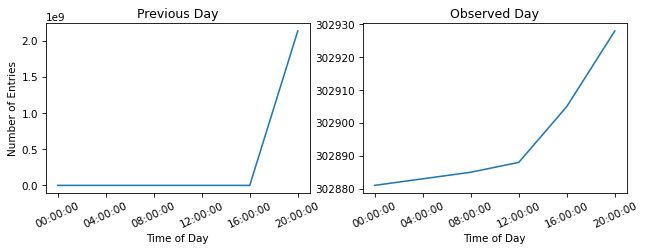

In [49]:
x = mask_inspect1.TIME
y = mask_inspect1.PASS_SUM

plt.figure(figsize=(10,3), dpi = 75)
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.xticks(rotation=25)
plt.title("Previous Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Entries")

x2 = mask_inspect2.TIME
y2 = mask_inspect2.PASS_SUM

plt.subplot(1, 2, 2)
plt.plot(x2, y2)
plt.xticks(rotation=25)
plt.title("Observed Day")
plt.xlabel("Time of Day")
plt.show();

In [50]:
# for the observations of extreme min/max for TOT_PASS, it appears the previous day has instances of missing data
# remove the extremes from the dataframe

diff_df['TOT_PASS'] = diff_df['TOT_PASS'].apply(lambda x: -50 if x > 100000 else x).astype(int)
tot_per = round((diff_df[diff_df.TOT_PASS < 0].TOT_PASS.count() / mta_df.ENTRIES.count())*100, 2)

print(f"The percent of TOT_PASS rows that have extreme or negative data is {tot_per}%.")

diff_df = diff_df.drop(diff_df[diff_df.TOT_PASS < 0].index)

The percent of TOT_PASS rows that have extreme or negative data is 0.82%.


In [51]:
# remove the extremes from the TOT_ENTRIES column as well

diff_df['TOT_ENTRIES'] = diff_df['TOT_ENTRIES'].apply(lambda x: -50 if x > 100000 else x).astype(int)
ent_per = round((diff_df[diff_df.TOT_ENTRIES < 0].TOT_ENTRIES.count() / mta_df.ENTRIES.count())*100, 2)

print(f"The percent of TOT_ENTRIES that have extreme data is {ent_per}%.")

diff_df = diff_df.drop(diff_df[diff_df.TOT_ENTRIES < 0].index)

The percent of TOT_ENTRIES that have extreme data is 0.21%.


In [52]:
# remove the extremes from the TOT_EXITS column as well

diff_df['TOT_EXITS'] = diff_df['TOT_EXITS'].apply(lambda x: -50 if x > 100000 else x).astype(int)
exit_per = round((diff_df[diff_df.TOT_EXITS < 0].TOT_EXITS.count() / mta_df.ENTRIES.count())*100, 2)

print(f"The percent of total_rows that have extreme data is {exit_per}%.")

diff_df = diff_df.drop(diff_df[diff_df.TOT_EXITS < 0].index)

The percent of total_rows that have extreme data is 0.07%.


In [53]:
# final inspect for total passage

diff_df['TOT_PASS'].describe().apply('{0:.2f}'.format)

count    2870303.00
mean         130.05
std          249.16
min            0.00
25%           14.00
50%           73.00
75%          186.00
max        78020.00
Name: TOT_PASS, dtype: object

In [54]:
# check total entries

diff_df['TOT_ENTRIES'].describe().apply('{0:.2f}'.format)

count    2870303.00
mean          60.43
std          154.50
min            0.00
25%            4.00
50%           26.00
75%           83.00
max        65507.00
Name: TOT_ENTRIES, dtype: object

In [55]:
# check total exits

diff_df['TOT_EXITS'].describe().apply('{0:.2f}'.format)

count    2870303.00
mean          69.62
std          136.44
min            0.00
25%            5.00
50%           30.00
75%           88.00
max        64070.00
Name: TOT_EXITS, dtype: object

In [56]:
# calculate the total amount of data removed from the data set

total_per = round(date_per + tot_per + ent_per + exit_per, 2)
print(f"The total amount of data that has been removed is {total_per}%.")

The total amount of data that has been removed is 2.12%.


In [57]:
# create a day of the week column and a week v. weekend column

diff_df['DAY_OF_WEEK'] = diff_df['DATE_TIME'].dt.day_name()
day_dict = {'Sunday':'7. SUN', 'Monday':'1. MON', 'Tuesday':'2. TUE', 'Wednesday':'3. WED', 'Thursday':'4. THU', 'Friday':'5. FRI', 'Saturday':'6. SAT'}
diff_df['DAY_OF_WEEK'].replace(day_dict, inplace=True)
diff_df['WEEK_WKND'] = diff_df['DAY_OF_WEEK'].apply(lambda x: 'WKND' if x == 'SAT' or x == 'SUN' else 'WEEK')

In [58]:
diff_df.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,PASS_SUM,TOT_PASS,TOT_ENTRIES,TOT_EXITS,DAY_OF_WEEK,WEEK_WKND
6,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 00:00:00,10169529,69,57,12,7. SUN,WEEK
7,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 04:00:00,10169536,7,6,1,7. SUN,WEEK
8,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 08:00:00,10169539,3,1,2,7. SUN,WEEK
9,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 12:00:00,10169586,47,8,39,7. SUN,WEEK
10,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 16:00:00,10169703,117,72,45,7. SUN,WEEK


In [59]:
# create a bin column for differnt time intervals throughout the day

my_bins = [0,6,9,16,19,22,24]
my_labels = ['1. 12-6 AM', '2. 6-9 AM', '3. 9-4 PM', '4. 4-7 PM', '5. 7-10 PM', '6. 10-12 AM']

diff_df['TIME_BINS'] = pd.cut(diff_df.DATE_TIME.dt.hour, bins = my_bins, labels = my_labels, right = False, include_lowest = True).astype(str)

In [60]:
diff_df.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,DATE_TIME,PASS_SUM,TOT_PASS,TOT_ENTRIES,TOT_EXITS,DAY_OF_WEEK,WEEK_WKND,TIME_BINS
6,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 00:00:00,10169529,69,57,12,7. SUN,WEEK,1. 12-6 AM
7,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 04:00:00,10169536,7,6,1,7. SUN,WEEK,1. 12-6 AM
8,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 08:00:00,10169539,3,1,2,7. SUN,WEEK,2. 6-9 AM
9,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 12:00:00,10169586,47,8,39,7. SUN,WEEK,3. 9-4 PM
10,A002,R051,02-00-00,456NQRW,59 ST,05/30/2021,2021-05-30 16:00:00,10169703,117,72,45,7. SUN,WEEK,4. 4-7 PM


In [61]:
# remove columns no longer needed

diff_df.drop(['C/A', 'UNIT', 'SCP', 'DATE_TIME', 'PASS_SUM'], axis=1, inplace=True)

In [62]:
diff_df.head()

,LINENAME,STATION,DATE,TOT_PASS,TOT_ENTRIES,TOT_EXITS,DAY_OF_WEEK,WEEK_WKND,TIME_BINS
6,456NQRW,59 ST,05/30/2021,69,57,12,7. SUN,WEEK,1. 12-6 AM
7,456NQRW,59 ST,05/30/2021,7,6,1,7. SUN,WEEK,1. 12-6 AM
8,456NQRW,59 ST,05/30/2021,3,1,2,7. SUN,WEEK,2. 6-9 AM
9,456NQRW,59 ST,05/30/2021,47,8,39,7. SUN,WEEK,3. 9-4 PM
10,456NQRW,59 ST,05/30/2021,117,72,45,7. SUN,WEEK,4. 4-7 PM


In [63]:
diff_df.shape

(2870303, 9)

In [64]:
# merge the geo_df with the daily_change dataframe

df = geo_df.merge(diff_df, on=['STATION', 'LINENAME'], how='right')

In [65]:
df.head()

,STATION,LINENAME,LONGITUDE,LATITUDE,BOROUGH,COLLEGE,COLLEGE_DIST,DATE,TOT_PASS,TOT_ENTRIES,TOT_EXITS,DAY_OF_WEEK,WEEK_WKND,TIME_BINS
0,59 ST,456NQRW,-74.01788099953987,40.6413616662838,Brooklyn,None,None,05/30/2021,69,57,12,7. SUN,WEEK,1. 12-6 AM
1,59 ST,456NQRW,-74.01788099953987,40.6413616662838,Brooklyn,None,None,05/30/2021,7,6,1,7. SUN,WEEK,1. 12-6 AM
2,59 ST,456NQRW,-74.01788099953987,40.6413616662838,Brooklyn,None,None,05/30/2021,3,1,2,7. SUN,WEEK,2. 6-9 AM
3,59 ST,456NQRW,-74.01788099953987,40.6413616662838,Brooklyn,None,None,05/30/2021,47,8,39,7. SUN,WEEK,3. 9-4 PM
4,59 ST,456NQRW,-74.01788099953987,40.6413616662838,Brooklyn,None,None,05/30/2021,117,72,45,7. SUN,WEEK,4. 4-7 PM


In [66]:
df = df[['STATION', 'LINENAME', 'BOROUGH', 'DATE', 'TIME_BINS', 'DAY_OF_WEEK', 'WEEK_WKND', 'LONGITUDE', 'LATITUDE', 'COLLEGE', 'COLLEGE_DIST', 'TOT_ENTRIES', 'TOT_EXITS', 'TOT_PASS']] 

In [67]:
df.head()

,STATION,LINENAME,BOROUGH,DATE,TIME_BINS,DAY_OF_WEEK,WEEK_WKND,LONGITUDE,LATITUDE,COLLEGE,COLLEGE_DIST,TOT_ENTRIES,TOT_EXITS,TOT_PASS
0,59 ST,456NQRW,Brooklyn,05/30/2021,1. 12-6 AM,7. SUN,WEEK,-74.01788099953987,40.6413616662838,None,None,57,12,69
1,59 ST,456NQRW,Brooklyn,05/30/2021,1. 12-6 AM,7. SUN,WEEK,-74.01788099953987,40.6413616662838,None,None,6,1,7
2,59 ST,456NQRW,Brooklyn,05/30/2021,2. 6-9 AM,7. SUN,WEEK,-74.01788099953987,40.6413616662838,None,None,1,2,3
3,59 ST,456NQRW,Brooklyn,05/30/2021,3. 9-4 PM,7. SUN,WEEK,-74.01788099953987,40.6413616662838,None,None,8,39,47
4,59 ST,456NQRW,Brooklyn,05/30/2021,4. 4-7 PM,7. SUN,WEEK,-74.01788099953987,40.6413616662838,None,None,72,45,117


In [68]:
# ensure desired dtypes for each column

df.iloc[:, :-3] = df.iloc[:, :-3].astype(str)

In [69]:
df.iloc[:, -3:] = df.iloc[:, -3:].astype(int)

In [70]:
df.dtypes

STATION         object
LINENAME        object
BOROUGH         object
DATE            object
TIME_BINS       object
DAY_OF_WEEK     object
WEEK_WKND       object
LONGITUDE       object
LATITUDE        object
COLLEGE         object
COLLEGE_DIST    object
TOT_ENTRIES      int64
TOT_EXITS        int64
TOT_PASS         int64
dtype: object

In [71]:
df.shape

(2870303, 14)

In [72]:
# export dataframe to a csv for graphical data anlysis

df.to_csv('mta_geo_final.csv', index=False)